Resolvendo o sistema linear...


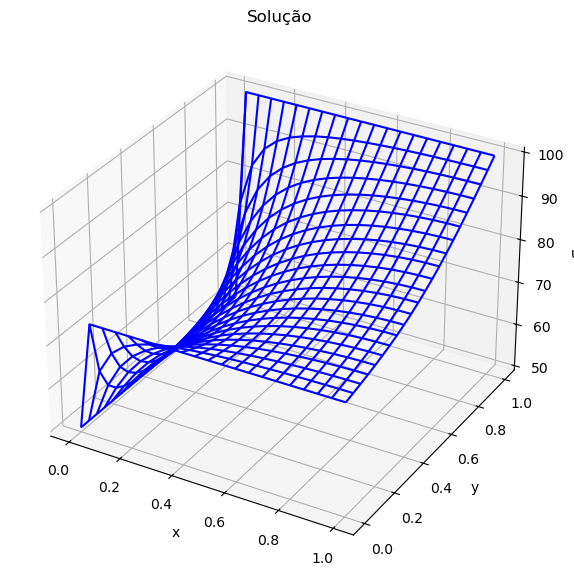

In [15]:
import numpy as np
from scipy.sparse import lil_matrix, csc_matrix, kron, eye, block_diag
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt

# --- 1. Parâmetros do Problema ---
LX = 1.0
LY = 1.0

# Número de pontos *internos* e de Neumann (fronteira direita)
NX_incognitas = 20  # Pontos de x=h até x=LX
NY_incognitas = 20  # Pontos de y=h até y=LY-h

NX_total = NX_incognitas + 1 # Total de pontos em x, incluindo x=0
NY_total = NY_incognitas + 2 # Total de pontos em y, incluindo y=0, y=LY

# h = LX / NX_incognitas # Espaçamento da malha
h = 0.001

# Condições de contorno de Dirichlet
u_A = 75.0  # y=0
u_B = 100.0 # y=1
u_C = 50.0  # x=0

# --- 2. Construção das Matrizes Unidimensionais ---

# Matriz 1D para a direção X (dimensões: NX_incognitas x NX_incognitas)
Ax = lil_matrix((NX_incognitas, NX_incognitas))
for i in range(NX_incognitas):
    if i < NX_incognitas - 1: # Pontos internos em X
        Ax[i, i] = 2.0
        if i > 0:
            Ax[i, i-1] = -1.0
        if i < NX_incognitas - 1:
            Ax[i, i+1] = -1.0
    else: # Ponto de Neumann na fronteira direita
        Ax[i, i] = 2.0
        Ax[i, i-1] = -2.0

# Matriz 1D para a direção Y (dimensões: NY_incognitas x NY_incognitas)
Ay = lil_matrix((NY_incognitas, NY_incognitas))
for j in range(NY_incognitas):
    Ay[j, j] = 2.0
    if j > 0:
        Ay[j, j-1] = -1.0
    if j < NY_incognitas - 1:
        Ay[j, j+1] = -1.0

# --- 3. Construção da Matriz do Sistema 2D com Kronecker ---
I_y = eye(NY_incognitas)
I_x = eye(NX_incognitas)

A = kron(I_y, Ax) + kron(Ay, I_x)
A = csc_matrix(A) # Converter para formato otimizado

# --- 4. Construção do Vetor b ---
N_incognitas = NX_incognitas * NY_incognitas
b = np.zeros(N_incognitas)

for j in range(NY_incognitas):
    for i in range(NX_incognitas):
        k = i + j * NX_incognitas
        
        if i == 0:
            b[k] += u_C
        
        if j == 0:
            b[k] += u_A

        if j == NY_incognitas - 1:
            b[k] += u_B

# --- 5. Resolvendo o Sistema Linear ---
print("Resolvendo o sistema linear...")
u_flat = spsolve(A, b)

# --- 6. Remodelando e Visualizando a Solução ---
u_incognitas = u_flat.reshape((NY_incognitas, NX_incognitas))
u = np.zeros((NY_total, NX_total))

u[1:NY_total-1, 1:NX_total] = u_incognitas
u[:, 0] = u_C
u[0, :] = u_A
u[NY_total-1, :] = u_B

# Tratando os cantos
u[0, 0] = u_C # Canto inferior esquerdo é 50
u[NY_total-1, 0] = u_C # Canto superior esquerdo é 50
u[0, NX_total-1] = u_A # Canto inferior direito é 75
u[NY_total-1, NX_total-1] = u_B # Canto superior direito é 100

# print("Solução u:")
# print(u)

# Visualização da solução
X, Y = np.meshgrid(np.linspace(0, LX, NX_total), np.linspace(0, LY, NY_total))

fig = plt.figure(figsize=(16, 7))
ax1 = fig.add_subplot(projection='3d')
ax1.plot_wireframe(X, Y, u, color='blue')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('u')
ax1.set_title('Solução')
plt.show()